# Regional variation in the organisation of cues to the Japanese stop voicing contrast
## James Tanner and Yōsuke Igarashi

The goal of this analysis is to examine how a range of Japanese dialects vary in the realisation of the stop voicing contrast (i.e., distinguish between voiced {b, d, g} and voiceless {p, t, k} stops).

A range of studies have demonstrated that the Japanese stop voicing contrast is undergoing change: specifically, that the use of Voice Onset Time (VOT) to mark the contrast has begun to be replaced by other acoustic cues such as fundamental frequency (F0, 'pitch'), breathiness, and the amplitude of the stop burst. As the organisation of cues to the contrast are currently undergoing change, it is the case that the change has not fully diffused across the country, potentially leading to regional variation in how the contrast is realised acoustically.

This study examines the acoustic profile of stops produed in a range of Japanese regional dialects, and considers how each dialect varies in the relative use of the acoustic cues to the contrast. The data reported here consists of elicitations made in laboratory conditions: the target word is placed in the initial position of a carrier sentence (「WORD」って言うんは). The target word varies as a function of voicing (voiced vs voiceless), place of articulation (velar vs alveolar vs labial), and the following vowel (/a/, /e/, /i/, /o/, /u/).

First, the distribution of dialects with respect to each cue (i.e., what each dialect's mean value for each cue is) is examined visually, which provides information about how the respective use of each cue is differentiated across regions. In order to get a robust quantitative estimate of the cue variation across dialects, the data will be subsequently modelled.

In [230]:
## load libraries
library(tidyverse)     ## general data wrangling and plotting
library(GGally)        ## pairwise plotting
library(factoextra)    ## PCA visualisation
library(gridExtra)     ## multiplots

options(width = 100, repr.plot.width = 10, repr.plot.height = 10) ## notebook display settings

The first step of the analysis is to load the tabular data. As part of the original data collection, the trials (labelled as `utterance`) were hand-annotated. In addition, the release of the stop burst and the onset of periodic voicing (i.e., VOT) were also hand-labelled. As manual labels were not available for the other cues, the values for F0 and amplitude were automatically estimated and extracted using the `parselmouth` library (a python interface for Praat).

To calculate F0, the a Praat Pitch file was generated from the sound file using setting recommendations from Eager (2015). A PointProcess object, which denotes estimated voicing pulses, was derived from this Pitch file. F0 was estimated from the nearest voicing pulse from the hand-annotated onset of voicing (labelled as `voicing` in the dataset). Whilst this method has provided initial values, there remain a number of issues (including both inaccurate and missing values).

Burst amplitude was estimated by generating an Intensity object for the sound file (also using `parselmouth`), and extracting the Intensity (in dB) from the release of the stop burst (labelled as `release` in the dataset). To account for variation across sound files, the file-average intensity was also extracted.

Tokens with currently-missing acoustic measures are excluded from further analysis: after applying a new acoustic measurement technique, these tokens will be included in the analysis.

In [108]:
## read data
df <- read.csv('../data/JP_STOP_MEASURES.csv')

## remove NA values from the acoustic measures
df <- drop_na(df, f0, burst_amplitude, h1mnh2)

Before analysing the data, the acoustic variables must be scaled and processed. First, the amplitude of the stop burst is centred by subtracting the mean amplitude for the sound file: because each recording was produced in different conditions, this should remove some degree of by-file variation irrelevant to the study.

VOT is converted from seconds to milliseconds by multiplying by 1000, in order to make the scale comparable with previous studies on VOT.

As F0 is highly dependent on a speaker's physical characteristics (i.e., vocal tract length), F0 is normalised within-speaker using z-normalisation across all of a speaker's tokens.

In [109]:
## make normalisation function
z_normalise <- function(x, mu, sig) {
    z <- (x - mu) / sig
}

In [110]:
## calculate mean/sd F0 for each speaker
speakerF0 <- df %>%
    group_by(speaker) %>%
    summarise(meanF0 = mean(f0), sdF0 = sd(f0))

df <- left_join(df, speakerF0, by = 'speaker')
## normalise/centre acoustic columns
df <- df %>%
    mutate(VOT = VOT * 1000,                       ## convert VOT to milliseconds
           F0 = z_normalise(f0, meanF0, sdF0),     ## apply F0 normalisation
           amp = burst_amplitude - file_amplitude) ## subtract file-average amplitude from burst


By plotting the voiced vs voiceless values as a scatterplot, the size and direction of the contrast can be interpreted as where a dialect is positioned within the 2-dimensional space. The blue dashed line reflects where the voiced and voiceless value for a cue would be equal.

First examining VOT (plot 1), most dialects are positioned to the right of the line, indicating that nearly all dialects have a higher VOT for voiceless stops than for voiced. It is unclear why one dialect (Settsu?) appears to have reversed VOT contrast, and needs to be investigated further.

The dialectal variation for F0 is interesting, where dialects fall on both sides of the line, indicating that some dialects show opposite F0 voicing contrasts from each other. For burst amplitude, all dialects (except for Settsu?) show a amplitude contrast where voiced stops show a higher average amplitude than voiceless stops.

*Todo: plot speaker averages for each dialect to see how similar each speaker's values are (within dialect)*

In [111]:
## calculate average value for each dialect
MeasureDf <- df %>%
    ## first get averages for each speaker
    group_by(dialect_eng, speaker, phone_voicing) %>%
    summarise(VOT = mean(VOT), F0 = mean(F0), amplitude = mean(amp), h1mnh2 = mean(h1mnh2)) %>%
    ungroup() %>%

    ## create dialect averages as mean of means
    group_by(dialect_eng, phone_voicing) %>%
    summarise(VOT = mean(VOT), F0 = mean(F0), amplitude = mean(amplitude), h1mnh2 = mean(h1mnh2)) %>%

    ## pivot values so voiced + voiceless are columns
    gather(key = measure, value = value, -dialect_eng, -phone_voicing) %>%
    spread(phone_voicing, value)

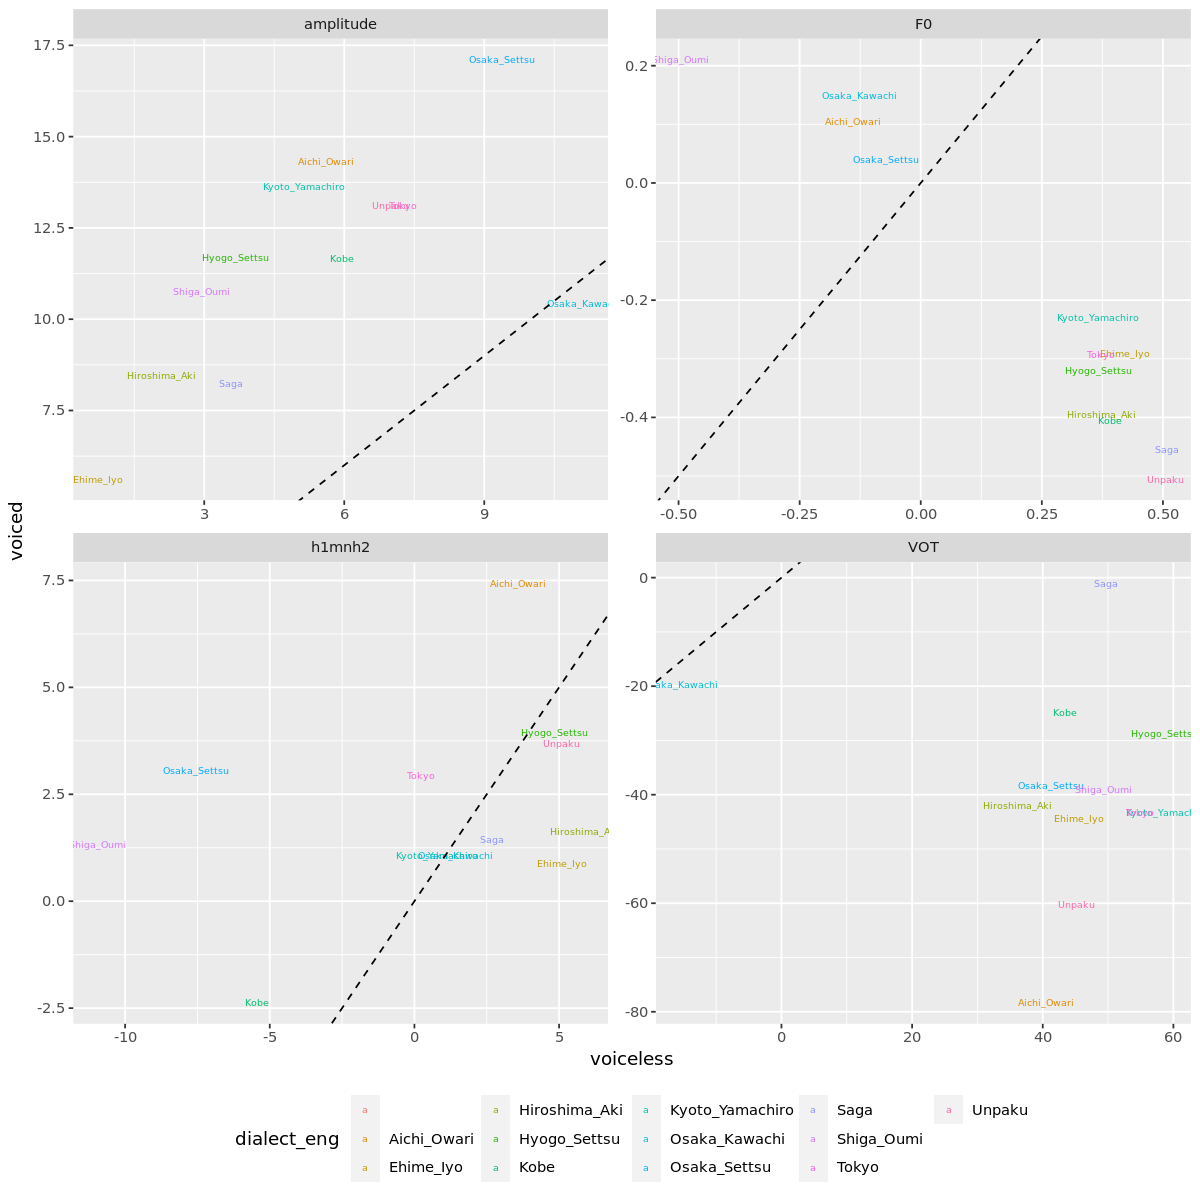

In [231]:
## make scatterplots of the dialects for
## each acoustic measure
MeasureDf %>%
    ggplot(aes(x = voiceless, y = voiced)) +              ## voiceless on the x axis; voiced on y axis
        geom_text(aes(label = dialect_eng, colour = dialect_eng), size = 2) + ## colour each dialect
        geom_abline(lty = 2) +                            ## add y=x line to show contrast
        facet_wrap(~measure, scales = 'free') +           ## plot each measure with own scales
        theme(legend.position = 'bottom')                 ## put dialect legend at the bottom

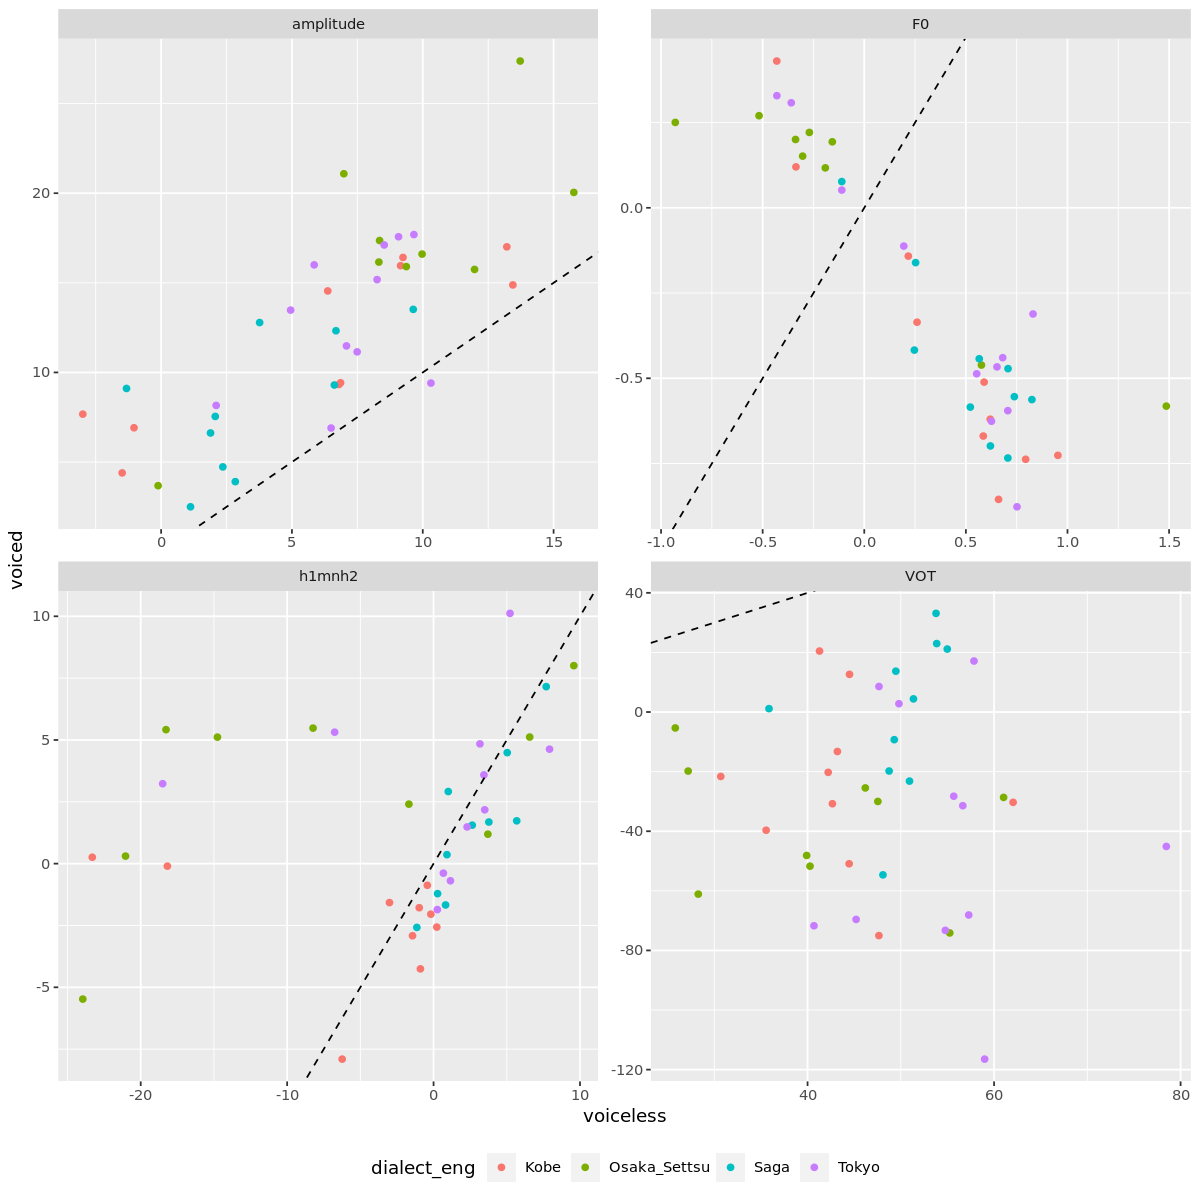

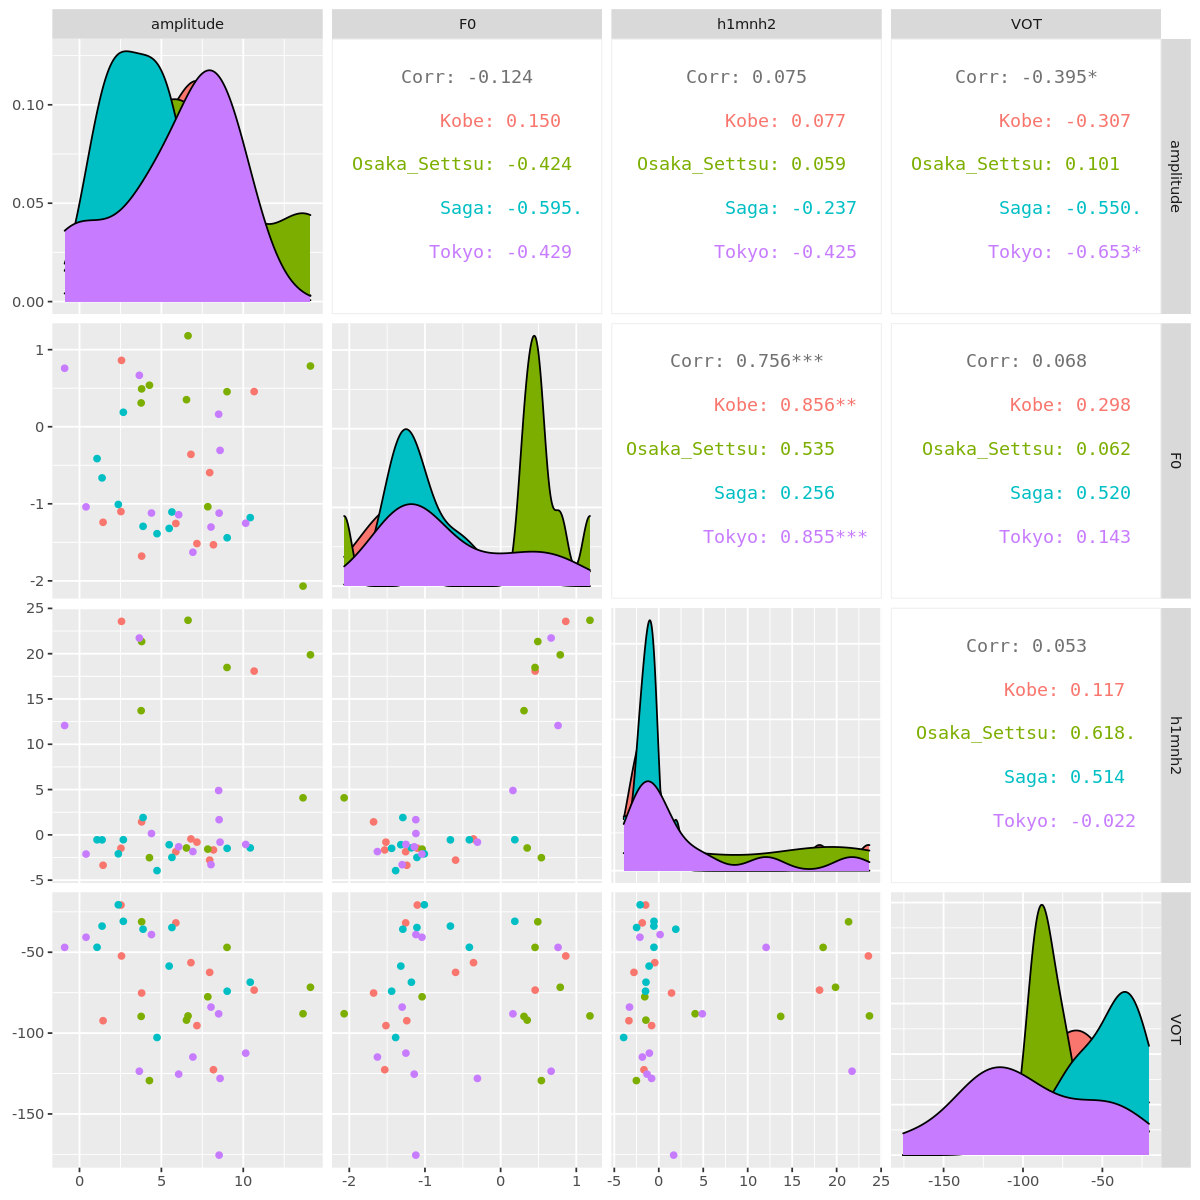

In [232]:
SpeakerMeasures <- df %>%
    group_by(dialect_eng, speaker, phone_voicing) %>%
    summarise(VOT = mean(VOT), F0 = mean(F0), amplitude = mean(amp), h1mnh2 = mean(h1mnh2)) %>%
    gather(key = 'measure', value = 'value', -speaker, -dialect_eng, -phone_voicing) %>%
    spread(phone_voicing, value) %>%
    filter(dialect_eng %in% c("Tokyo", "Saga", "Kobe", "Osaka_Settsu"))

SpeakerMeasures %>%
    ggplot(aes(x = voiceless, y = voiced)) +
        geom_point(aes(colour = dialect_eng)) +
        geom_abline(lty = 2) +
        facet_wrap(~measure, scales = 'free') +
        theme(legend.position = 'bottom')

SpeakerMeasures %>%
    mutate(contrast = voiced - voiceless) %>%
    select(-voiced, -voiceless) %>%
    spread(measure, contrast) %>%
    ggpairs(columns = 3:6, ggplot2::aes(colour = dialect_eng))

In [236]:
## make a dataframe of the voicing contrast
## wrt to each acoustic cue for each speaker
SpeakerPCADf <- SpeakerMeasures %>%
    mutate(contrast = voiced - voiceless) %>%
    select(-voiced, -voiceless) %>%
    spread(measure, contrast) %>%
    ungroup() %>%
    group_by(dialect_eng) %>%
    nest()

## hacky way of converting speaker names to rows
SpeakerPCADf$data[[1]] <- column_to_rownames(SpeakerPCADf$data[[1]], 'speaker')
SpeakerPCADf$data[[2]] <- column_to_rownames(SpeakerPCADf$data[[2]], 'speaker')
SpeakerPCADf$data[[3]] <- column_to_rownames(SpeakerPCADf$data[[3]], 'speaker')
SpeakerPCADf$data[[4]] <- column_to_rownames(SpeakerPCADf$data[[4]], 'speaker')

SpeakerPCADf <- SpeakerPCADf %>%
    mutate(PCA = map(data, ~prcomp(.x, scale = TRUE, center = TRUE)))
SpeakerPCADf$data
SpeakerPCADf$PCA

,amplitude,F0,h1mnh2,VOT
,<dbl>,<dbl>,<dbl>,<dbl>
kfah,7.949536,-0.5952589,-2.7891681,-62.44286
kfki,6.805216,-0.3584764,-0.4507391,-56.44464
kfmk,10.665505,0.4562678,18.0783362,-73.42357
kfmm,5.883450,-1.2550195,-1.8605588,-31.85131
kfrm,2.564639,0.8608689,23.5667196,-52.31188
kmkh,1.439660,-1.2400875,-3.3561926,-92.33923
kmki,7.170972,-1.5159323,-0.8042523,-95.36471
kmkn,3.794745,-1.6787905,1.4339394,-75.21560
kmks,2.530195,-1.1009731,-1.4807045,-20.81795


[[1]]
Standard deviations (1, .., p=4):
[1] 1.3973431 1.1384855 0.8004985 0.3323930

Rotation (n x k) = (4 x 4):
                  PC1         PC2          PC3        PC4
amplitude -0.07383654 -0.74270573  0.652011290  0.1334827
F0        -0.69292797 -0.06509222 -0.005616088 -0.7180406
h1mnh2    -0.66250489 -0.12093734 -0.346471261  0.6530077
VOT       -0.27474764  0.65538184  0.674394100  0.2004519

[[2]]
Standard deviations (1, .., p=4):
[1] 1.3660806 1.1664541 0.7816536 0.4027734

Rotation (n x k) = (4 x 4):
                 PC1        PC2        PC3        PC4
amplitude -0.1539145  0.7226020 -0.6184935  0.2676236
F0         0.5262924 -0.4768500 -0.4559951  0.5363756
h1mnh2     0.6710778  0.1979203 -0.2286618 -0.6769017
VOT        0.4989801  0.4596607  0.5977023  0.4271802

[[3]]
Standard deviations (1, .., p=4):
[1] 1.5364930 0.9317090 0.6445097 0.5964184

Rotation (n x k) = (4 x 4):
                 PC1        PC2        PC3        PC4
amplitude -0.5185471  0.4162457 -0.5235782  0

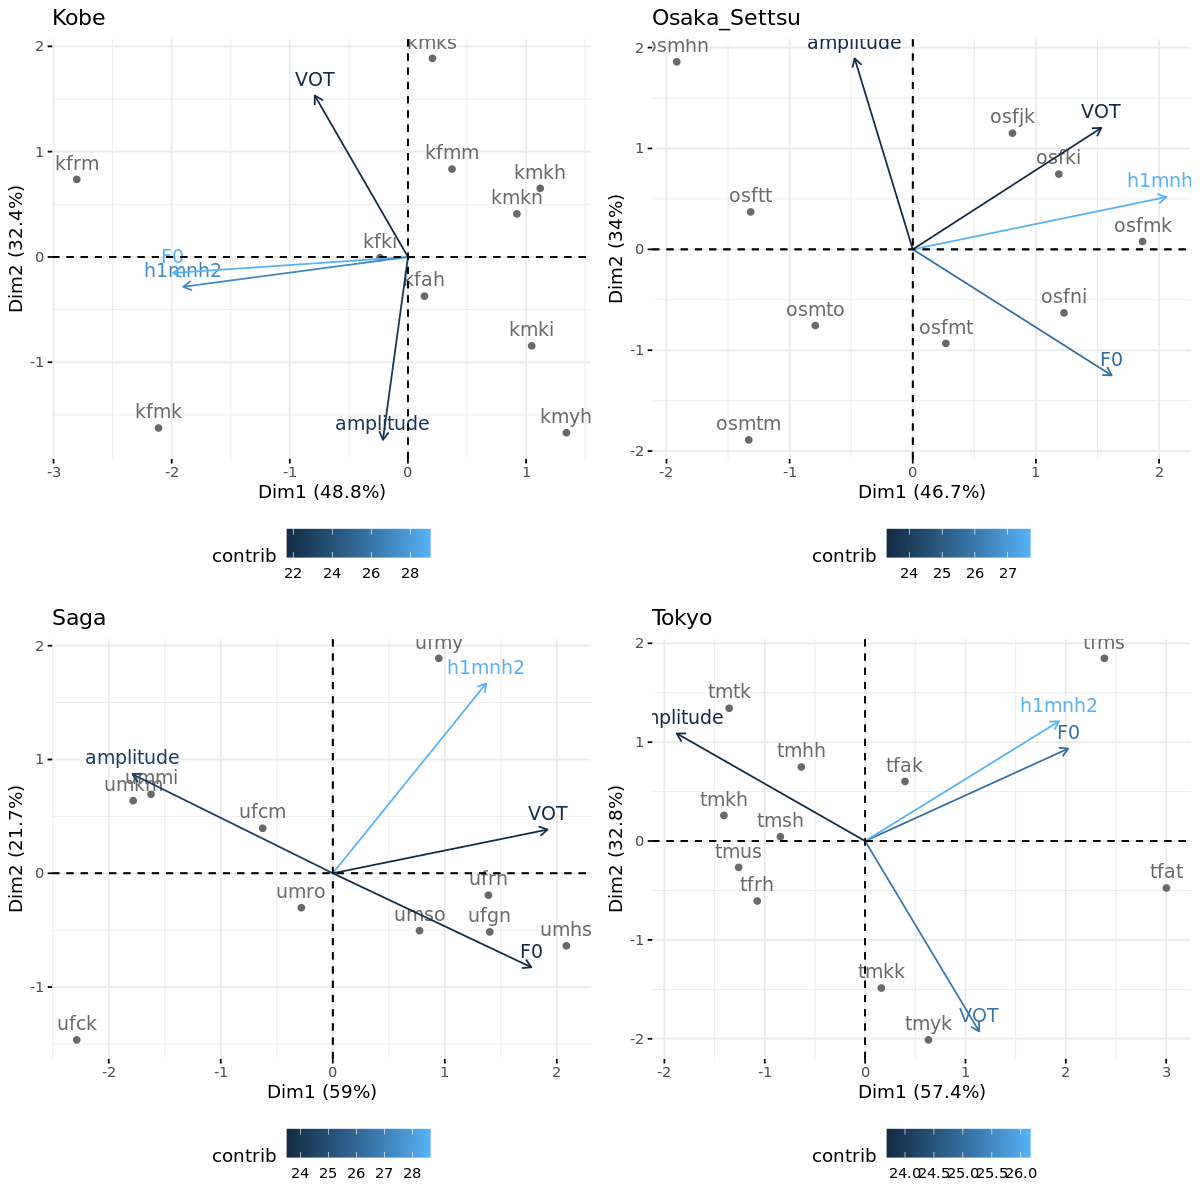

In [237]:

plots <- list()

for (i in 1:nrow(SpeakerPCADf)) {
    ## get dialect name and extract PCA
    dialect <- SpeakerPCADf$dialect_eng[[i]]
    pca <- SpeakerPCADf$PCA[[i]]
    
    pcaplot <- fviz_pca_biplot(pca, col.var = 'contrib', col.ind = "#696969") +
        ggtitle(dialect) +
        theme(legend.position = 'bottom')
    plots[[i]] <- pcaplot
}

grid.arrange(plots[[1]], plots[[2]], plots[[3]], plots[[4]])
